In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

## Создаем Tensorflow Dataset'ы 

In [ ]:
batch_size=16
image_size=(100, 100)

Подготовка изображений

In [ ]:
import shutil
import os

In [ ]:
# Каталог с набором данных
data_dir = 'data'
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для тестирования
test_dir = 'test'
# Часть набора данных для тестирования
test_data_portion = 0.15
# Часть набора данных для проверки
val_data_portion = 0.15
# Количество элементов данных в одном классе
nb_images = 108

In [ ]:
def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name, "Potato_with_solanine"))
    os.makedirs(os.path.join(dir_name, "Healthy_potato"))    

In [ ]:
create_directory(train_dir)
create_directory(test_dir)

In [ ]:
def copy_images(start_index, end_index, source_dir, dest_dir):
    for i in range(start_index, end_index):
        shutil.copy2(os.path.join(source_dir, "solanine (" + str(i) + ").png"), 
                    os.path.join(dest_dir, "Potato_with_solanine"))
        shutil.copy2(os.path.join(source_dir, "healthy (" + str(i) + ").png"), 
                   os.path.join(dest_dir, "Healthy_potato"))

In [ ]:
start_test_data_idx = int(nb_images * (1 - test_data_portion))
print(start_test_data_idx) 

91


In [ ]:
copy_images(1, start_test_data_idx, data_dir, train_dir)
copy_images(start_test_data_idx, nb_images, data_dir, test_dir)

**Набор данных для обучения**

In [ ]:
train_dataset = image_dataset_from_directory('train',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 180 files belonging to 2 classes.
Using 162 files for training.


**Проверочный набор данных**

In [ ]:
validation_dataset = image_dataset_from_directory('train',
                                             subset='validation',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 180 files belonging to 2 classes.
Using 18 files for validation.


Названия классов в наборах данных.

In [ ]:
class_names = train_dataset.class_names
class_names

['Healthy_potato', 'Potato_with_solanine']

**Примеры изображений**

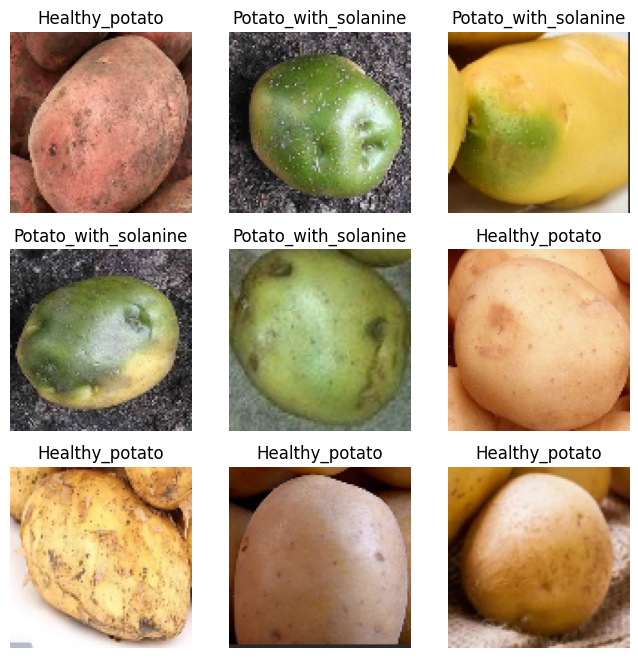

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Набор данных для тестирования**

In [ ]:
test_dataset = image_dataset_from_directory('test',
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 34 files belonging to 2 classes.


In [ ]:
classes = test_dataset.class_names; classes

['Healthy_potato', 'Potato_with_solanine']

## Настраиваем производительность TensorFlow DataSet'ов

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Создаем нейронную сеть

In [ ]:
# Создаем последовательную модель
model = Sequential()
# Сверточный слой
model.add(Conv2D(16, (5, 5), padding='same', 
                 input_shape=(100, 100, 3), activation='relu'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Полносвязная часть нейронной сети для классификации
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# Выходной слой, 2 нейрона по количеству классов
model.add(Dense(2, activation='softmax'))

**Компилируем модель**

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'],
              run_eagerly=True)

## Обучаем нейронную сеть

In [ ]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=15,
                    verbose=2)

Epoch 1/15
11/11 - 8s - loss: 15.7621 - accuracy: 0.4938 - val_loss: 0.8746 - val_accuracy: 0.6111 - 8s/epoch - 749ms/step
Epoch 2/15
11/11 - 8s - loss: 0.7679 - accuracy: 0.6049 - val_loss: 0.5750 - val_accuracy: 0.8333 - 8s/epoch - 742ms/step
Epoch 3/15
11/11 - 7s - loss: 0.6619 - accuracy: 0.6358 - val_loss: 0.5300 - val_accuracy: 0.7222 - 7s/epoch - 596ms/step
Epoch 4/15
11/11 - 6s - loss: 0.6236 - accuracy: 0.6543 - val_loss: 0.4240 - val_accuracy: 0.8333 - 6s/epoch - 591ms/step
Epoch 5/15
11/11 - 7s - loss: 0.4825 - accuracy: 0.7716 - val_loss: 0.2599 - val_accuracy: 0.8889 - 7s/epoch - 600ms/step
Epoch 6/15
11/11 - 8s - loss: 0.4419 - accuracy: 0.7963 - val_loss: 0.1986 - val_accuracy: 0.9444 - 8s/epoch - 697ms/step
Epoch 7/15
11/11 - 7s - loss: 0.2909 - accuracy: 0.8765 - val_loss: 0.1370 - val_accuracy: 0.9444 - 7s/epoch - 640ms/step
Epoch 8/15
11/11 - 8s - loss: 0.1889 - accuracy: 0.9198 - val_loss: 0.1811 - val_accuracy: 0.8889 - 8s/epoch - 748ms/step
Epoch 9/15
11/11 - 7s -

## Оцениваем качетсво обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

3/3 [==============================] - 0s 84ms/step - loss: 1.8977 - accuracy: 0.6765


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 67.6471


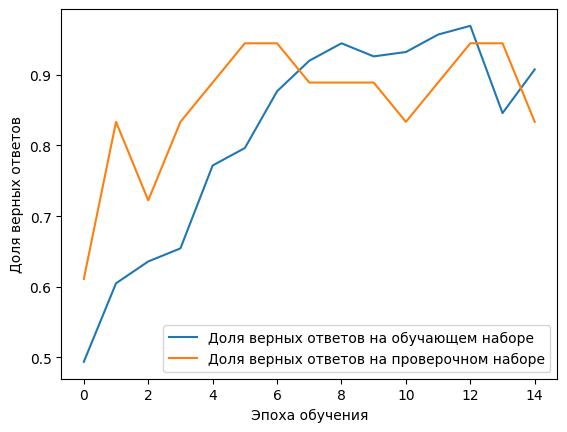

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

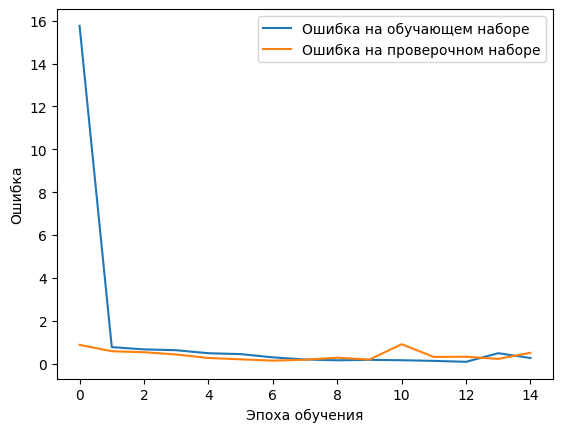

In [ ]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Сохраняем обученную нейронную сеть

In [ ]:
model.save("Potato_quality.h5")

In [ ]:
files.download("Potato_quality.h5")

## Используем сеть для распознавания наличия соланина в клубне картофеля

In [ ]:
prediction = model.predict(test_dataset)

3/3 [==============================] - 0s 71ms/step


In [ ]:
prediction

array([[9.99376714e-01, 6.23301021e-04],
       [8.84781599e-01, 1.15218446e-01],
       [9.99999344e-01, 6.07047525e-07],
       [9.59457457e-01, 4.05426547e-02],
       [9.99999940e-01, 3.97875372e-10],
       [2.35683910e-04, 9.99764204e-01],
       [9.99968469e-01, 3.14536992e-05],
       [9.99993861e-01, 6.10517509e-06],
       [2.62136281e-01, 7.37863660e-01],
       [9.99999940e-01, 7.94940710e-11],
       [2.13842347e-01, 7.86157668e-01],
       [6.86495155e-02, 9.31350529e-01],
       [9.99996006e-01, 3.92297216e-06],
       [9.83084977e-01, 1.69150475e-02],
       [9.99999821e-01, 1.69445485e-07],
       [9.11358595e-01, 8.86413902e-02],
       [6.57851040e-01, 3.42148960e-01],
       [9.99999940e-01, 7.32433225e-10],
       [2.53330022e-01, 7.46670008e-01],
       [9.97130752e-01, 2.86919856e-03],
       [9.99524653e-01, 4.75296925e-04],
       [5.53014755e-01, 4.46985185e-01],
       [6.19806111e-01, 3.80193979e-01],
       [9.99999821e-01, 1.14576025e-07],
       [9.999842

In [ ]:
for elem in prediction:
  predictionz = np.argmax(elem)
  print("Номер класса:", predictionz)
  print("Название класса:", classes[predictionz])

Номер класса: 0
Название класса: Healthy_potato
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 1
Название класса: Potato_with_solanine
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 1
Название класса: Potato_with_solanine
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 1
Название класса: Potato_with_solanine
Номер класса: 1
Название класса: Potato_with_solanine
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 0
Название класса: Healthy_potato
Номер класса: 1
Название класса: Potato_with_solanine
Номер класса: 0
Название класса: Healthy_potato
Номер клас

Выберем случайное изображение и проверим

In [ ]:
data_sample = next(iter(test_dataset))
sample_image = data_sample[0].numpy()[0]
sample_label = classes[data_sample[1].numpy()[0]]
prediction = np.argmax(model.predict(sample_image.reshape(-1, *sample_image.shape))[0])
print("Номер класса:", prediction)
print("Название класса:", classes[prediction])

1/1 [==============================] - 0s 64ms/step
Номер класса: 0
Название класса: Healthy_potato


(-0.5, 99.5, 99.5, -0.5)

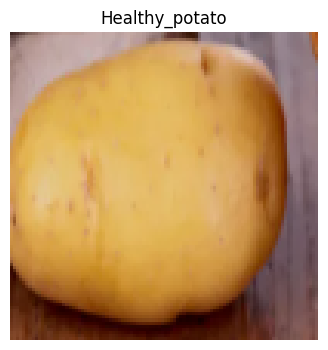

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(data_sample[0].numpy()[0].astype("uint8"))
plt.title(classes[prediction])
plt.axis("off")

#Оценка качества работы нейронной сети на разных условиях

Частичное перекрытие здорового растения листьями

In [ ]:
create_directory('dirt_test')

In [ ]:
dirt_dataset = image_dataset_from_directory('dirt_test',
                                             batch_size=2,
                                             image_size=image_size)

Found 20 files belonging to 2 classes.


In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(dirt_dataset, verbose=1)

10/10 [==============================] - 1s 54ms/step - loss: 0.9090 - accuracy: 0.7500


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 75.0


1/1 [==============================] - 0s 65ms/step


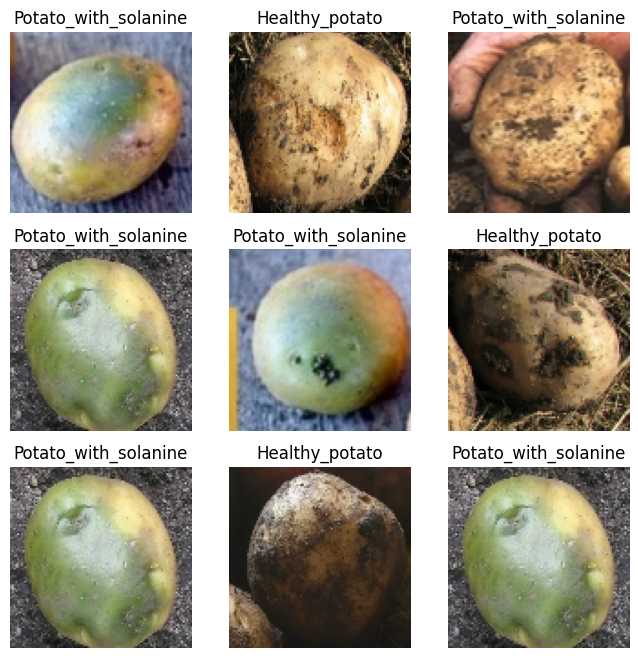

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(9):
  data_sample = next(iter(dirt_dataset))
  sample_image = data_sample[0].numpy()[0]
  sample_label = classes[data_sample[1].numpy()[0]]
  prediction = np.argmax(model.predict(sample_image.reshape(-1, *sample_image.shape))[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(data_sample[0].numpy()[0].astype("uint8"))
  plt.title(classes[prediction])
  plt.axis("off")